*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.6.3
IPython 6.2.1

torch 0.3.0.post4


# Model Zoo -- Logistic Regression

Implementation of *classic* logistic regression for binary class labels.

## Preparing a toy dataset

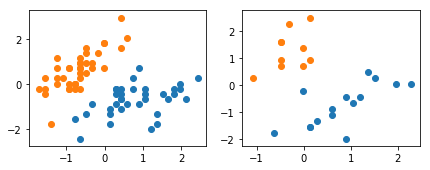

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO

##########################
### DATASET
##########################

ds = np.lib.DataSource()
fp = ds.open('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')

x = np.genfromtxt(BytesIO(fp.read().encode()), delimiter=',', usecols=range(2), max_rows=100)
y = np.zeros(100)
y[50:] = 1

np.random.seed(1)
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X_test, y_test = x[idx[:25]], y[idx[:25]]
X_train, y_train = x[idx[25:]], y[idx[25:]]
mu, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train, X_test = (X_train - mu) / std, (X_test - mu) / std

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1])
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1])
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1])
plt.show()

## Low-level implementation with manual gradients

In [3]:
import torch
import torch.nn.functional as F


def custom_where(cond, x_1, x_2):
    return (cond * x_1) + ((1-cond) * x_2)


class LogisticRegression1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1)
        self.bias = torch.zeros(1)

    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias)
        probas = self._sigmoid(linear)
        return probas
        
    def backward(self, probas, y):  
        errors = y - probas.view(-1)
        return errors
            
    def predict_labels(self, x):
        probas = self.forward(x)
        labels = custom_where(probas >= .5, 1, 0)
        return labels    
            
    def evaluate(self, x, y):
        labels = self.predict_labels(x).float()
        accuracy = torch.sum(labels.view(-1) == y) / y.size()[0]
        return accuracy
    
    def _sigmoid(self, z):
        return 1. / (1. + torch.exp(-z))
    
    def _logit_cost(self, y, proba):
        tmp1 = torch.mm(-y.view(1, -1), torch.log(proba))
        tmp2 = torch.mm((1 - y).view(1, -1), torch.log(1 - proba))
        return tmp1 - tmp2
    
    def train(self, x, y, num_epochs, learning_rate=0.01):
        for e in range(num_epochs):
            
            #### Compute outputs ####
            probas = self.forward(x)
            
            #### Compute gradients ####
            errors = self.backward(probas, y)
            neg_grad = torch.mm(x.transpose(0, 1), errors.view(-1, 1))
            
            #### Update weights ####
            self.weights += learning_rate * neg_grad
            self.bias += learning_rate * torch.sum(errors)
            
            #### Logging ####
            print('Epoch: %03d' % (e+1), end="")
            print(' | Train ACC: %.3f' % self.evaluate(x, y), end="")
            print(' | Cost: %.3f' % self._logit_cost(y, self.forward(x)))

In [4]:
logr = LogisticRegression1(num_features=2)
X_train_tensor, y_train_tensor = torch.Tensor(X_train), torch.Tensor(y_train)
logr.train(X_train_tensor, y_train_tensor, num_epochs=10, learning_rate=0.1)

print('\nModel parameters:')
print('  Weights: %s' % logr.weights)
print('  Bias: %s' % logr.bias)

Epoch: 001 | Train ACC: 0.987 | Cost: 5.581
Epoch: 002 | Train ACC: 0.987 | Cost: 4.882
Epoch: 003 | Train ACC: 1.000 | Cost: 4.381
Epoch: 004 | Train ACC: 1.000 | Cost: 3.998
Epoch: 005 | Train ACC: 1.000 | Cost: 3.693
Epoch: 006 | Train ACC: 1.000 | Cost: 3.443
Epoch: 007 | Train ACC: 1.000 | Cost: 3.232
Epoch: 008 | Train ACC: 1.000 | Cost: 3.052
Epoch: 009 | Train ACC: 1.000 | Cost: 2.896
Epoch: 010 | Train ACC: 1.000 | Cost: 2.758

Model parameters:
  Weights: 
 4.2267
-2.9613
[torch.FloatTensor of size 2x1]

  Bias: 
1.00000e-02 *
  9.9419
[torch.FloatTensor of size 1]



In [5]:
X_test_tensor, y_test_tensor = torch.Tensor(X_test), torch.Tensor(y_test)

test_acc = logr.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.3f%%' % (test_acc*100))

Test set accuracy: 100.000%


## Low-level implementation using autograd

In [6]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [7]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable


def custom_where(cond, x_1, x_2):
    return (cond * x_1) + ((1-cond) * x_2)


class LogisticRegression2():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = Variable(torch.zeros(num_features, 1).type(dtype),
                                requires_grad=True)
        self.bias = Variable(torch.zeros(1).type(dtype),
                             requires_grad=True)

    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias)
        probas = self._sigmoid(linear)
        return probas
                    
    def predict_labels(self, x):
        probas = self.forward(x)
        labels = custom_where((probas >= .5).float(), 1, 0)
        return labels    
            
    def evaluate(self, x, y):
        labels = self.predict_labels(x)
        accuracy = (torch.sum(labels.view(-1) == y.view(-1))).float() / y.size()[0]
        return accuracy
    
    def _sigmoid(self, z):
        return 1. / (1. + torch.exp(-z))
    
    def _logit_cost(self, y, proba):
        tmp1 = torch.mm(-y.view(1, -1), torch.log(proba))
        tmp2 = torch.mm((1 - y).view(1, -1), torch.log(1 - proba))
        return tmp1 - tmp2
    
    def train(self, x, y, num_epochs, learning_rate=0.01):
        
        x_var = Variable(x.type(dtype), requires_grad=False)
        y_var = Variable(y.type(dtype), requires_grad=False)
        
        for e in range(num_epochs):
            
            #### Compute outputs ####
            proba = self.forward(x_var)
            cost = self._logit_cost(y_var, proba)
            
            #### Compute gradients ####
            cost.backward()
            
            #### Update weights ####
            self.weights.data -= learning_rate * self.weights.grad.data
            self.bias.data -= learning_rate * self.bias.grad.data
      
            #### Reset gradients to zero for next iteration ####
            self.weights.grad.data.zero_()
            self.bias.grad.data.zero_()
    
            #### Logging ####
            print('Epoch: %03d' % (e+1), end="")
            print(' | Train ACC: %.3f' % self.evaluate(x_var, y_var), end="")
            print(' | Cost: %.3f' % self._logit_cost(y_var, self.forward(x_var)))
            


In [8]:
logr = LogisticRegression2(num_features=2)
X_train_tensor, y_train_tensor = torch.Tensor(X_train), torch.Tensor(y_train)
logr.train(X_train_tensor, y_train_tensor, num_epochs=10, learning_rate=0.1)

print('\nModel parameters:')
print('  Weights: %s' % logr.weights)
print('  Bias: %s' % logr.bias)

Epoch: 001 | Train ACC: 0.987 | Cost: 5.581
Epoch: 002 | Train ACC: 0.987 | Cost: 4.882
Epoch: 003 | Train ACC: 1.000 | Cost: 4.381
Epoch: 004 | Train ACC: 1.000 | Cost: 3.998
Epoch: 005 | Train ACC: 1.000 | Cost: 3.693
Epoch: 006 | Train ACC: 1.000 | Cost: 3.443
Epoch: 007 | Train ACC: 1.000 | Cost: 3.232
Epoch: 008 | Train ACC: 1.000 | Cost: 3.052
Epoch: 009 | Train ACC: 1.000 | Cost: 2.896
Epoch: 010 | Train ACC: 1.000 | Cost: 2.758

Model parameters:
  Weights: Variable containing:
 4.2267
-2.9613
[torch.FloatTensor of size 2x1]

  Bias: Variable containing:
1.00000e-02 *
  9.9419
[torch.FloatTensor of size 1]



In [9]:
X_test_var = Variable(torch.Tensor(X_test).type(dtype), requires_grad=False)
y_test_var = Variable(torch.Tensor(y_test).type(dtype), requires_grad=False)

test_acc = logr.evaluate(X_test_var, y_test_var)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 100.00%


## High-level implementation using the nn.Module API

In [10]:
class LogisticRegression3(torch.nn.Module):

    def __init__(self, num_features):
        super(LogisticRegression3, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)
        # initialize weights to zeros here,
        # since we used zero weights in the
        # manual approach
        self.linear.weight.data.zero_()
        self.linear.bias.data.zero_()
        
    def forward(self, x):
        logits = self.linear(x)
        probas = F.sigmoid(logits)
        return probas

model = LogisticRegression3(num_features=2)

In [11]:
##### Define cost function and set up optimizer #####
cost_fn = torch.nn.BCELoss(size_average=False)
# average_size=False to match results in
# manual approach, where we did not normalize
# the cost by the batch size
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [12]:
def comp_accuracy(label_var, pred_probas):
    pred_labels = custom_where((pred_probas > 0.5).float(), 1, 0).view(-1)
    acc = torch.sum(pred_labels == label_var.view(-1)).float() / label_var.size(0)
    return acc


num_epochs = 10

X_train_var = Variable(torch.Tensor(X_train), requires_grad=False)
y_train_var = Variable(torch.Tensor(y_train), requires_grad=False).view(-1, 1)


for epoch in range(num_epochs):
    
    #### Compute outputs ####
    out = model(X_train_var)
    
    #### Compute gradients ####
    cost = cost_fn(out, y_train_var)
    optimizer.zero_grad()
    cost.backward()
    
    #### Update weights ####  
    optimizer.step()
    
    #### Logging ####      
    pred_probas = model(X_train_var)
    acc = comp_accuracy(y_train_var, pred_probas)
    print('Epoch: %03d' % (epoch + 1), end="")
    print(' | Train ACC: %.3f' % acc, end="")
    print(' | Cost: %.3f' % cost_fn(pred_probas, y_train_var))


    
print('\nModel parameters:')
print('  Weights: %s' % model.linear.weight.data)
print('  Bias: %s' % model.linear.bias.data)

Epoch: 001 | Train ACC: 0.987 | Cost: 5.581
Epoch: 002 | Train ACC: 0.987 | Cost: 4.882
Epoch: 003 | Train ACC: 1.000 | Cost: 4.381
Epoch: 004 | Train ACC: 1.000 | Cost: 3.998
Epoch: 005 | Train ACC: 1.000 | Cost: 3.693
Epoch: 006 | Train ACC: 1.000 | Cost: 3.443
Epoch: 007 | Train ACC: 1.000 | Cost: 3.232
Epoch: 008 | Train ACC: 1.000 | Cost: 3.052
Epoch: 009 | Train ACC: 1.000 | Cost: 2.896
Epoch: 010 | Train ACC: 1.000 | Cost: 2.758

Model parameters:
  Weights: 
 4.2267 -2.9613
[torch.FloatTensor of size 1x2]

  Bias: 
1.00000e-02 *
  9.9419
[torch.FloatTensor of size 1]



In [13]:
X_test_var = Variable(torch.Tensor(X_test).type(dtype), requires_grad=False)
y_test_var = Variable(torch.Tensor(y_test).type(dtype), requires_grad=False)

pred_probas = model(X_test_var)
test_acc = comp_accuracy(y_test_var, pred_probas)

print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 100.00%
